# Seeds Dataset – Multiclass Classification with a Feed-Forward ANN



This notebook builds and evaluates a feed-forward artificial neural network (ANN) for multiclass classification on the UCI **Seeds** dataset.

We will:
1. Load and explore the data.
2. Preprocess (train–test split, scaling).
3. Design and train a Keras ANN with two hidden layers.
4. Compare two variants differing in a key hyperparameter (dropout rate).
5. Evaluate models on a test set (accuracy, precision, recall, F1-score).
6. Visualize a confusion matrix for the best model.


## University of Niagara Falls Canada
### DAMO640, Machine Learning, Sec 8
### Renan da Silva Sousa - NF1012001
### Professor: Dr. William Pourmajid

# Imports

## Install Tensorflow

In [8]:
import sys
print("Notebook Python:", sys.executable)

# Install into THIS exact Python:
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install tensorflow

Notebook Python: c:\ProgramData\anaconda3\python.exe
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Regular Imports

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)


## Imports and Reproducibility

In this cell we import all the libraries used in the project:

- **NumPy** and **Pandas** for numerical operations and data handling.
- **Matplotlib** for plotting.
- **scikit-learn** for train–test splitting, scaling, and evaluation metrics.
- **TensorFlow / Keras** for building and training the neural network.

We also set random seeds for NumPy and TensorFlow to make the experiments as reproducible as possible (i.e., getting similar results each time we run the notebook).


# Load Dataset

In [10]:
local_path = "../data/raw/seeds_dataset.txt"

# Column names specified in the assignment
columns = [
    "area",
    "perimeter",
    "compactness",
    "length_of_kernel",
    "width_of_kernel",
    "asymmetry_coefficient",
    "length_of_kernel_groove",
    "class"
]

df = pd.read_csv(local_path, delim_whitespace=True, header=None, names=columns)

df.head()


C:\Users\Renan\AppData\Local\Temp\ipykernel_15376\3586063234.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(local_path, delim_whitespace=True, header=None, names=columns)


,area,perimeter,compactness,length_of_kernel,width_of_kernel,asymmetry_coefficient,length_of_kernel_groove,class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


## Data Loading

Here we load the Seeds dataset from the local `data/raw/` folder in the repository.

Key points:

- The original file has **no header**, so we manually assign the 8 column names:
  - 7 numeric features describing wheat seed geometry.
  - 1 target column (`class`) with values 1, 2, or 3.
- The file uses **whitespace** as a separator, so we use `delim_whitespace=True`.

The table above shows the first few rows of the dataset, which helps confirm that the data was loaded correctly and the column names match the assignment description.


# EDA: Class Distribution & Summary Stats

Dataset shape: (210, 8)

Class distribution:
class
1    70
2    70
3    70
Name: count, dtype: int64


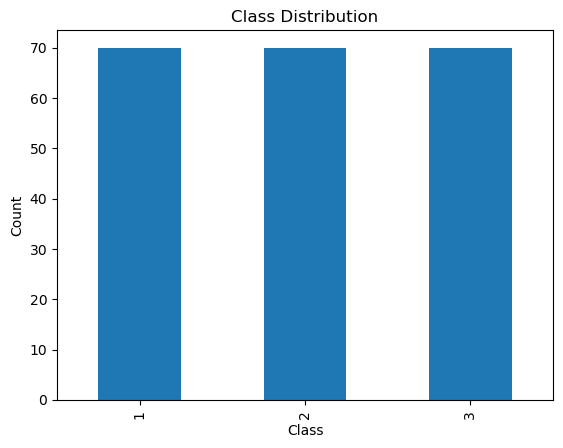

,mean,std
area,14.847524,2.909699
perimeter,14.559286,1.305959
compactness,0.870999,0.023629
length_of_kernel,5.628533,0.443063
width_of_kernel,3.258605,0.377714
asymmetry_coefficient,3.700201,1.503557
length_of_kernel_groove,5.408071,0.491480
class,2.000000,0.818448


In [11]:
print("Dataset shape:", df.shape)

# Class distribution
class_counts = df["class"].value_counts().sort_index()
print("\nClass distribution:")
print(class_counts)

plt.figure()
class_counts.plot(kind="bar")
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()

# Per-feature mean and std
summary_stats = df.describe().T[["mean", "std"]]
summary_stats


## Exploratory Data Analysis (EDA)

In this step we perform a quick EDA:

- **Dataset shape** tells us the number of samples (rows) and features (columns).
- **Class distribution** shows how many samples belong to each of the three wheat varieties.
- We also compute **mean** and **standard deviation** for each numeric feature.

### Observations

- The dataset shape should be **(210, 8)**: 210 samples and 8 columns (7 features + 1 target).
- The bar plot shows that classes are roughly **balanced** (around 70 samples per class), which is good for training a classifier.
- The summary statistics give us an idea of the **scale** and **variability** of each feature, which justifies the use of feature scaling before training the neural network.


# Preprocessing – Missing Values, Split, Scaling

In [ ]:
# Check for missing values
print("Missing values per column:")
print(df.isna().sum())

# Separate features and target
X = df.drop("class", axis=1).values
y = df["class"].values - 1  

# Train-test split (80/20), stratified, fixed random seed
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Scale features using StandardScaler (fit on train only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Missing values per column:
area                       0
perimeter                  0
compactness                0
length_of_kernel           0
width_of_kernel            0
asymmetry_coefficient      0
length_of_kernel_groove    0
class                      0
dtype: int64
Train shape: (168, 7)
Test shape: (42, 7)


## Preprocessing: Missing Values, Train/Test Split, and Scaling

Here we prepare the data for the neural network:

1. **Missing values**  
   We check for missing values in each column. As expected for this dataset, there are no missing entries.

2. **Feature/target split**  
   - `X` contains the 7 numeric features.
   - `y` contains the class labels (1, 2, or 3).

3. **Train–test split**  
   - We split the data into **80% training** and **20% test**.
   - We use `stratify=y` so that the class proportions are similar in both sets.
   - A fixed `random_state` (42) makes the split reproducible.

4. **Feature scaling**  
   - We apply `StandardScaler` so that each feature has approximately zero mean and unit variance.
   - The scaler is **fit on the training data only**, and then applied to both train and test sets, which avoids leaking information from the test set into the training process.

This preprocessing ensures the ANN receives features on a comparable scale, which generally helps training stability and convergence.


# Model Builder Function (with L2 + Dropout)

In [16]:
def build_ann(
    input_dim=7,
    hidden_units_1=16,
    hidden_units_2=8,
    dropout_rate=0.2,
    l2_lambda=1e-4,
    learning_rate=1e-3
):
    """
    Build and compile a feed-forward ANN (MLP) with:
    - 2 hidden layers
    - ReLU activation
    - L2 regularization
    - Dropout
    - Softmax output (3 classes)
    """
    model = Sequential()
    model.add(
        Dense(
            hidden_units_1,
            activation="relu",
            kernel_regularizer=l2(l2_lambda),
            input_shape=(input_dim,)
        )
    )
    model.add(Dropout(dropout_rate))

    model.add(
        Dense(
            hidden_units_2,
            activation="relu",
            kernel_regularizer=l2(l2_lambda)
        )
    )
    model.add(Dropout(dropout_rate))

    # Output layer: 3 classes, softmax
    model.add(Dense(3, activation="softmax"))

    # Sparse categorical crossentropy since labels are integers {1,2,3}
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


## ANN Architecture: Model Builder Function

This function builds a **feed-forward neural network (MLP)** with the following structure:

- **Input layer**: size 7 (one neuron per feature).
- **Hidden layer 1**: 16 units, ReLU activation, L2 regularization.
- **Dropout** layer after hidden layer 1.
- **Hidden layer 2**: 8 units, ReLU activation, L2 regularization.
- **Dropout** layer after hidden layer 2.
- **Output layer**: 3 units, softmax activation (one probability per class).

Regularization:

- **L2 weight decay (`l2_lambda`)** helps prevent large weights and overfitting.
- **Dropout (`dropout_rate`)** randomly disables a fraction of neurons during training, which also acts as regularization.

Training setup:

- **Loss**: `sparse_categorical_crossentropy` (appropriate because labels are integers 1/2/3).
- **Optimizer**: Adam with a small learning rate (default 0.001).
- **Metric**: overall classification accuracy.

Later, we will vary the **dropout rate** to see how this hyperparameter affects the model’s performance.


# Train Variant A (Dropout 0.2)

In [17]:
dropout_A = 0.2
model_A = build_ann(dropout_rate=dropout_A)

# Train with validation split
history_A = model_A.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    verbose=0
)

print("Variant A (dropout = {:.2f}) training finished.".format(dropout_A))


C:\Users\Renan\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Variant A (dropout = 0.20) training finished.


## Training – Variant A (Dropout = 0.2)

In this cell we train the first ANN variant:

- **Dropout rate**: 0.2 (20% of neurons dropped during training).
- **Epochs**: 100 (passes through the training data).
- **Batch size**: 16.
- **Validation split**: 20% of the training data is used for validation during training.

The `history_A` object stores the evolution of the **training** and **validation** loss and accuracy over the 100 epochs. We will use this later to visualize how well the model learned and whether it overfits or underfits.


# Train Variant B (Dropout 0.5)

In [18]:
dropout_B = 0.5
model_B = build_ann(dropout_rate=dropout_B)

history_B = model_B.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    verbose=0
)

print("Variant B (dropout = {:.2f}) training finished.".format(dropout_B))


Variant B (dropout = 0.50) training finished.


## Training – Variant B (Dropout = 0.5)

Here we train a second ANN variant that is **identical** to Variant A except for the dropout rate:

- **Dropout rate**: 0.5 (stronger regularization than 0.2).

By comparing `history_B` with `history_A`, we can see how increasing dropout affects:

- Convergence speed.
- Training accuracy.
- Validation accuracy (generalization performance).

This comparison directly addresses the hyperparameter analysis requested in the assignment.


# Plot Training & Validation Accuracy

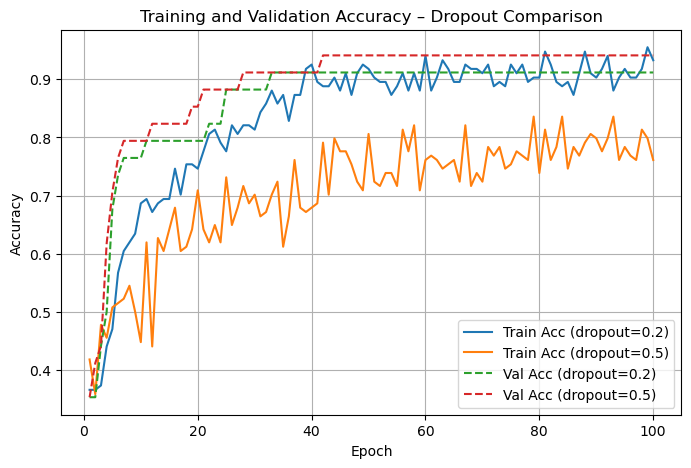

In [19]:
def plot_history_compare(history_A, history_B, label_A, label_B):
    epochs = range(1, len(history_A.history["accuracy"]) + 1)

    plt.figure(figsize=(8, 5))
    # Training accuracy
    plt.plot(epochs, history_A.history["accuracy"], label=f"Train Acc ({label_A})")
    plt.plot(epochs, history_B.history["accuracy"], label=f"Train Acc ({label_B})")

    # Validation accuracy
    plt.plot(epochs, history_A.history["val_accuracy"], linestyle="--", label=f"Val Acc ({label_A})")
    plt.plot(epochs, history_B.history["val_accuracy"], linestyle="--", label=f"Val Acc ({label_B})")

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy – Dropout Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history_compare(
    history_A,
    history_B,
    label_A=f"dropout={dropout_A}",
    label_B=f"dropout={dropout_B}"
)
